# Holy NLP! Understanding Part of Speech Tags, Dependency Parsing, and Named Entity Recognition
## Introduction

When we think of data science, we often think of statistical analysis of numbers. But, more and more frequently, organizations generate a lot of unstructured text data that can be quantified and analyzed. A few examples are  social network comments, product reviews, emails, interview transcripts.

For analyzing text, data scientists often use Nautral Language Processing (NLP). In this blog post we'll 3 we'll walk through 3 common NLP tasks and look at how they can be used together to analyze text.  The three tasks we'll cover are:

1. **Part of Speech Tagging** - What type of word is this?
2. **Dependency Parsing** - How is this word related to other words in this sentence?
3. **Named Entity Recognition** - Is this word a proper noun?

We're going use the `spaCy` python library to apply these three tools together to discover who the major actors are in the Bible and what actions they take. From there, we'll see if we can make an interesting visualization with this structured data. 

This approach can be applied to any problem where you have a large collection of text documents and you want to understand who the major entities are, where they appear in the document, and what they're doing. DocumentCloud uses a [similar approach](https://www.documentcloud.org/public/search/) to this with their "View Entities" analysis option.

### Tokens & Part of Speech Tagging

One way to extract meaning from text is to analyze individual words. The processes of breaking up a text into words is called tokenization -- the resulting words are referred to as tokens. Punctuation marks are also tokens. Each token in a sentence has several attributes we can use for analysis. The part of speech of a word is one example: nouns are a person, place, or thing; verbs are actions or occurences; adjectives are words that describe nouns. Using these attributes, it's straightforward to create a summary of a piece of text by counting the most common nouns, verbs, and adjectives. 

Using `spaCy`, we can easily tokenize a piece of text and access the part of speech attribute for each token. As an example application, we'll tokenize the previous paragraph and count the most common nouns with the code below.  We'll also lemmatize the tokens, which gives the root form a word to help us standardize across forms of a word.

In [1]:
from collections import Counter
import spacy
from tabulate import tabulate
nlp = spacy.load('en_core_web_lg')

text = """
One way to extract meaning from text is to analyze individual words.
The processes of breaking up a text into words is called tokenization --
the resulting words are referred to as tokens.
Punctuation marks are also tokens.
Each token in a sentence has several attributes we can use for analysis.
The part of speech of a word is one example: nouns are a person, place, or thing;
verbs are actions or occurences; adjectives are words that describe nouns. 
Using these attributes, it's straightforward to create a summary of a piece of text
by counting the most common nouns, verbs, and adjectives. 
"""

doc = nlp(text)
noun_counter = Counter(token.lemma_ for token in doc if token.pos_ == 'NOUN')

print(tabulate(noun_counter.most_common(5), headers=['Noun', 'Count']))

Noun         Count
---------  -------
word             5
text             3
token            3
noun             3
attribute        2


### Dependency Parsing

Words also have relationships between them and there are several types of these relationships. For example, a noun can be the subject of the sentence, where it performs an action (a verb), as in "Jill laughed." Nouns can also be the subject of the sentence, where they're acted upon by the subject of the sentence, like John in the sentence in "Jill laughed at John."

Dependency parsing is a way to understand these relationships between words in a sentence. While both Jill and John are nouns in the sentence "Jill laughed at John," Jill is the subject who is doing the laughing and John is the object being laughed at. Dependency relations are a more fine-grained attribute available to understand the words through their relationships in a sentence.

These relationships between words can get complicated, depending on how a sentences are structured. The result of dependency parsing a sentence is a tree data structure, with the verb as the root.

Let's view a dependency parse of "The quick brown fox jumps over the lazy dog."

In [2]:
doc = nlp("The quick brown fox jumps over the lazy dog.")
spacy.displacy.render(doc, style='dep', options={'distance' : 140}, jupyter=True)

The dependency relation is also a token attribute, and `spaCy` has a [great API](https://spacy.io/api/token) for accessing different token attributes. Below we'll print out the text of each token, its dependency relation, and the text of its parent (head) token. 

In [3]:
token_dependencies = ((token.text, token.dep_, token.head.text) for token in doc)

print(tabulate(token_dependencies, headers=['Token', 'Dependency Relation', 'Parent Token']))

Token    Dependency Relation    Parent Token
-------  ---------------------  --------------
The      det                    fox
quick    amod                   fox
brown    amod                   fox
fox      nsubj                  jumps
jumps    ROOT                   jumps
over     prep                   jumps
the      det                    dog
lazy     amod                   dog
dog      pobj                   over
.        punct                  jumps


As a lead into our analysis, we care about any tokens with an `nobj` relation, indicating that they're the object in the sentence. In the example sentence, this would mean we want to capture the word "fox".

### Named Entity Recognition

Finally there's named entity recognition. Named Entities are the proper nouns of sentences. Computers have gotten pretty good at figuring out if they're in a sentence and also classifying what type of entity they are.

`sPacy` handles Named Entity Recognition at the document level, since the name of an entity can span several tokens. An individual token is labeled as part of an entity using an [IOB scheme](https://spacy.io/usage/linguistic-features#section-named-entities) to flag the beginning, inside, and outside of an entity. 

In the code below, we'll print all the named entities at the document level using `doc.ents`. Then, we'll print each token, its IOB annotation, its entity type (if it's part of an entity).

The example sentence we'll use is "Jill laughed at John Johnson."

In [4]:
doc = nlp("Jill laughed at John Johnson.")

entity_types = ((ent.text, ent.label_) for ent in doc.ents)
print(tabulate(entity_types, headers=['Entity', 'Entity Type']))
print()
token_entity_info = ((token.text, token.ent_iob_, token.ent_type_,) for token in doc)
print(tabulate(token_entity_info, headers=['Token', 'IOB Annotation', 'Entity Type']))

Entity        Entity Type
------------  -------------
Jill          PERSON
John Johnson  PERSON

Token    IOB Annotation    Entity Type
-------  ----------------  -------------
Jill     B                 PERSON
laughed  O
at       O
John     B                 PERSON
Johnson  I                 PERSON
.        O


## Real World Example: NLPing the Bible
Each method mentioned above is pretty great on their own, but the real power of natural language processing comes when we combined these methods to extract information that follows linguistic patterns. We can use part of speech tagging, dependency parsing, and named entity recognition to understand all the actors and their actions within a large body of text. The Bible is a great example to apply these methods due to its length and broad cast of characters.

The data we're importing contains one object per Bible verse. Verses are used as an reference scheme for parts of the Bible, and usually contains one or more sentences of text. We're going to go through each verse and extract the subject, identify if it's a person, and pull out the action that person does.

First let's load up the Bible as JSON from a GitHub repository. Then, we'll pull out the text from each verse, send the text through spaCy to do the dependency parsing and tagging, and store the resulting documents. We'll also time how long it takes to parse each verse to give us an idea of performance of spaCy.

In [5]:
import requests

r = requests.get('https://github.com/tushortz/Bible/raw/master/json/kjv.json')
bible_json = [line['fields'] for line in r.json()]
print('Number of Verses:', len(bible_json))

text_generator = (line['text'] for line in bible_json)

%time verse_docs = [doc for doc in nlp.pipe(text_generator, n_threads=-1)]

Number of Verses: 31102
CPU times: user 4min 13s, sys: 40.5 s, total: 4min 53s
Wall time: 2min 53s


We've parsed the text from the json into `verse_docs` in a little over 3 minutes, about 160 verses a second. For reference, here's what the first 3 rows of `bible_json` look like:


```json
[{'book_id': 1,
  'chapter': 1,
  'comment': '',
  'text': 'In the beginning God created the heaven and the earth.',
  'verse': 1},
 {'book_id': 1,
  'chapter': 1,
  'comment': '',
  'text': 'And the earth was without form, and void; and darkness was upon the face of the deep. And the Spirit of God moved upon the face of the waters.',
  'verse': 2},
 {'book_id': 1,
  'chapter': 1,
  'comment': '',
  'text': 'And God said, Let there be light: and there was light.',
  'verse': 3}]
```

### Using Token Attributes

In order to extract the actors and actions, we're going to iterate through all of the tokens in a verse and consider 3 factors:
1. Is the token the subject of the sentence (is it's dependency relation `nsubj`?)
2. Is the parent of the token a verb? (This should usually be true, but there are sometimes conflicts between the POS tagger and dependency parsing, and we'll play it safe. Also, I'm not a linguist so there may be some other weird edge cases) 
3. Is the token a named entity that's a person? We don't want to extract any nouns that aren't people. (For simplicity, we're only going to extract first names)

If our token meets the above three conditions, we're going to collect the following attributes: 
1. The text of the noun/entity Token
2. The Span (phrase) that includes the noun and verb
3. The verb
4. The log probability of the verb occuring in standard English text (using log here because these probabilities are very small)
5. The verse number

In [6]:
actors_and_actions = []

def token_is_subject_with_action(token):
    nsubj = token.dep_ == 'nsubj'
    head_verb = token.head.pos_ == 'VERB'
    person = token.ent_type_ == 'PERSON'
    return nsubj and head_verb and person

for verse, doc in enumerate(verse_docs):
    for token in doc:
        if token_is_subject_with_action(token):
            span = doc[token.head.left_edge.i:token.head.right_edge.i+1]
            data = dict(name=token.orth_,
                        span=span.text,
                        verb=token.head.lower_,
                        log_prob=token.head.prob,
                        verse=verse)
            actors_and_actions.append(data)

print(len(actors_and_actions))

5878


## Analysis

We've got a list of all the actors and their actions that we've extracted. For a quick analysis, let's do two things:

1. Figure out the most common action (verb) for each person. 
2. Figure out the most _unique_ action for each person. We'll determine this as the verb that has the lowest probability of appearing in English text.

In [7]:
import pandas as pd

action_df = pd.DataFrame(actors_and_actions)

print('Unique Names:', action_df['name'].nunique())

most_common = (action_df
    .groupby(['name', 'verb'])
    .size()
    .groupby(level=0, group_keys=False)
    .nlargest(1)
    .rename('Count')
    .reset_index(level=1)
    .rename(columns={
        'verb': 'Most Common'
    })
)

# exclude log prob < -20, those indicate absence in the model vocabulary
most_unique = (action_df[action_df['log_prob'] > -20]
    .groupby(['name', 'verb'])['log_prob']
    .min()
    .groupby(level=0, group_keys=False)
    .nsmallest(1)
    .rename('Log Prob.')
    .reset_index(level = 1)
    .rename(columns={
        'verb': 'Most Unique'
    })
)

# SO groupby credit
# https: //stackoverflow.com/questions/27842613/pandas-groupby-sort-within-groups

Unique Names: 534


Let's take a look at the top 15 actors by verb counts and their most common verb.

In [8]:
most_common.sort_values('Count', ascending=False).head(15)

,Most Common,Count
name,,
LORD,said,197
Jesus,said,89
David,said,88
Moses,said,62
Saul,said,42
Ye,are,34
Samuel,said,28
Blessed,be,24
God,said,23


Looks like a lot of people said things in the Bible, with the exception of Solomon who made a lot of things.

And what were the most unique verbs, as measured by their probability of occurence?
(We'll drop duplicates here so each word is unique)

In [9]:
(most_unique
 .drop_duplicates('Most Unique')
 .sort_values('Log Prob.', ascending=True)
 .head(15)
)

,Most Unique,Log Prob.
name,,
Abraham,sojourned,-19.502029
John,forbad,-19.497028
Saul,compassed,-19.282370
David,tarried,-19.168381
Whosoever,smiteth,-19.147064
Haman,standeth,-19.006294
Jehoahaz,besought,-18.932726
Benjamin,ravin,-18.910282
Jeroboam,drave,-18.904749


Looks like we've got some interesting new words to learn! My favorites are [discomfited](https://www.merriam-webster.com/dictionary/discomfited) and [ravin](https://www.merriam-webster.com/dictionary/ravin).

### Visualization

Let's visualize our results next. We're going to take the top 50 names with the most actions and plot which verse those actions occur in the whole text. We'll also draw vertical lines where each book of the Bible starts. The names will be sorted in order of first appearance.

This should give us an idea at which point in the Bible each of these characters were the most active.

We'll add in some separators to separate different sections of the Bible. Not being a Biblical scholar myself, I used the divisions from [here](https://www.thoughtco.com/how-the-books-of-the-bible-are-organized-363393), which are as follows:

**Old Testament:**

- **The Pentateuch, or the Books of the Law:** Genesis, Exodus, Leviticus, Numbers, and Deuteronomy.
- **Old Testament Historical Books:** Joshua, Judges, Ruth, 1 Samuel, 2 Samuel, 1 Kings, 2 Kings, 1 Chronicles, 2 Chronicles, Ezra, Nehemiah, and Esther.
- **Wisdom Literature:** Job, Psalms, Proverbs, Ecclesiastes, and Song of Solomon.
- **The Prophets:** Isaiah, Jeremiah, Lamentations, Ezekiel, Daniel, Hosea, Joel, Amos, Obadiah, Jonah, Micah, Nahum, Habakkuk, Zephaniah, Haggai, Zechariah, and Malachi.

**New Testament:**

- **The Gospels:** Matthew, Mark, Luke, and John.
- **New Testament Historical Books:** Acts
- **Epistles:** Romans, 1 Corinthians, 2 Corinthians, Galatians, Ephesians, Philippians, Colossians, 1 Thessalonians, 2 Thessalonians, 1 Timothy, 2 Timothy, Titus, Philemon, Hebrews, James, 1 Peter, 2 Peter, 1 John, 2 John, 3 John, and Jude.
- **Prophecy / Apocalyptic Literature:** Revelation


In addition, we'll separate the Old Testament from the New Testament with a red indicator line.

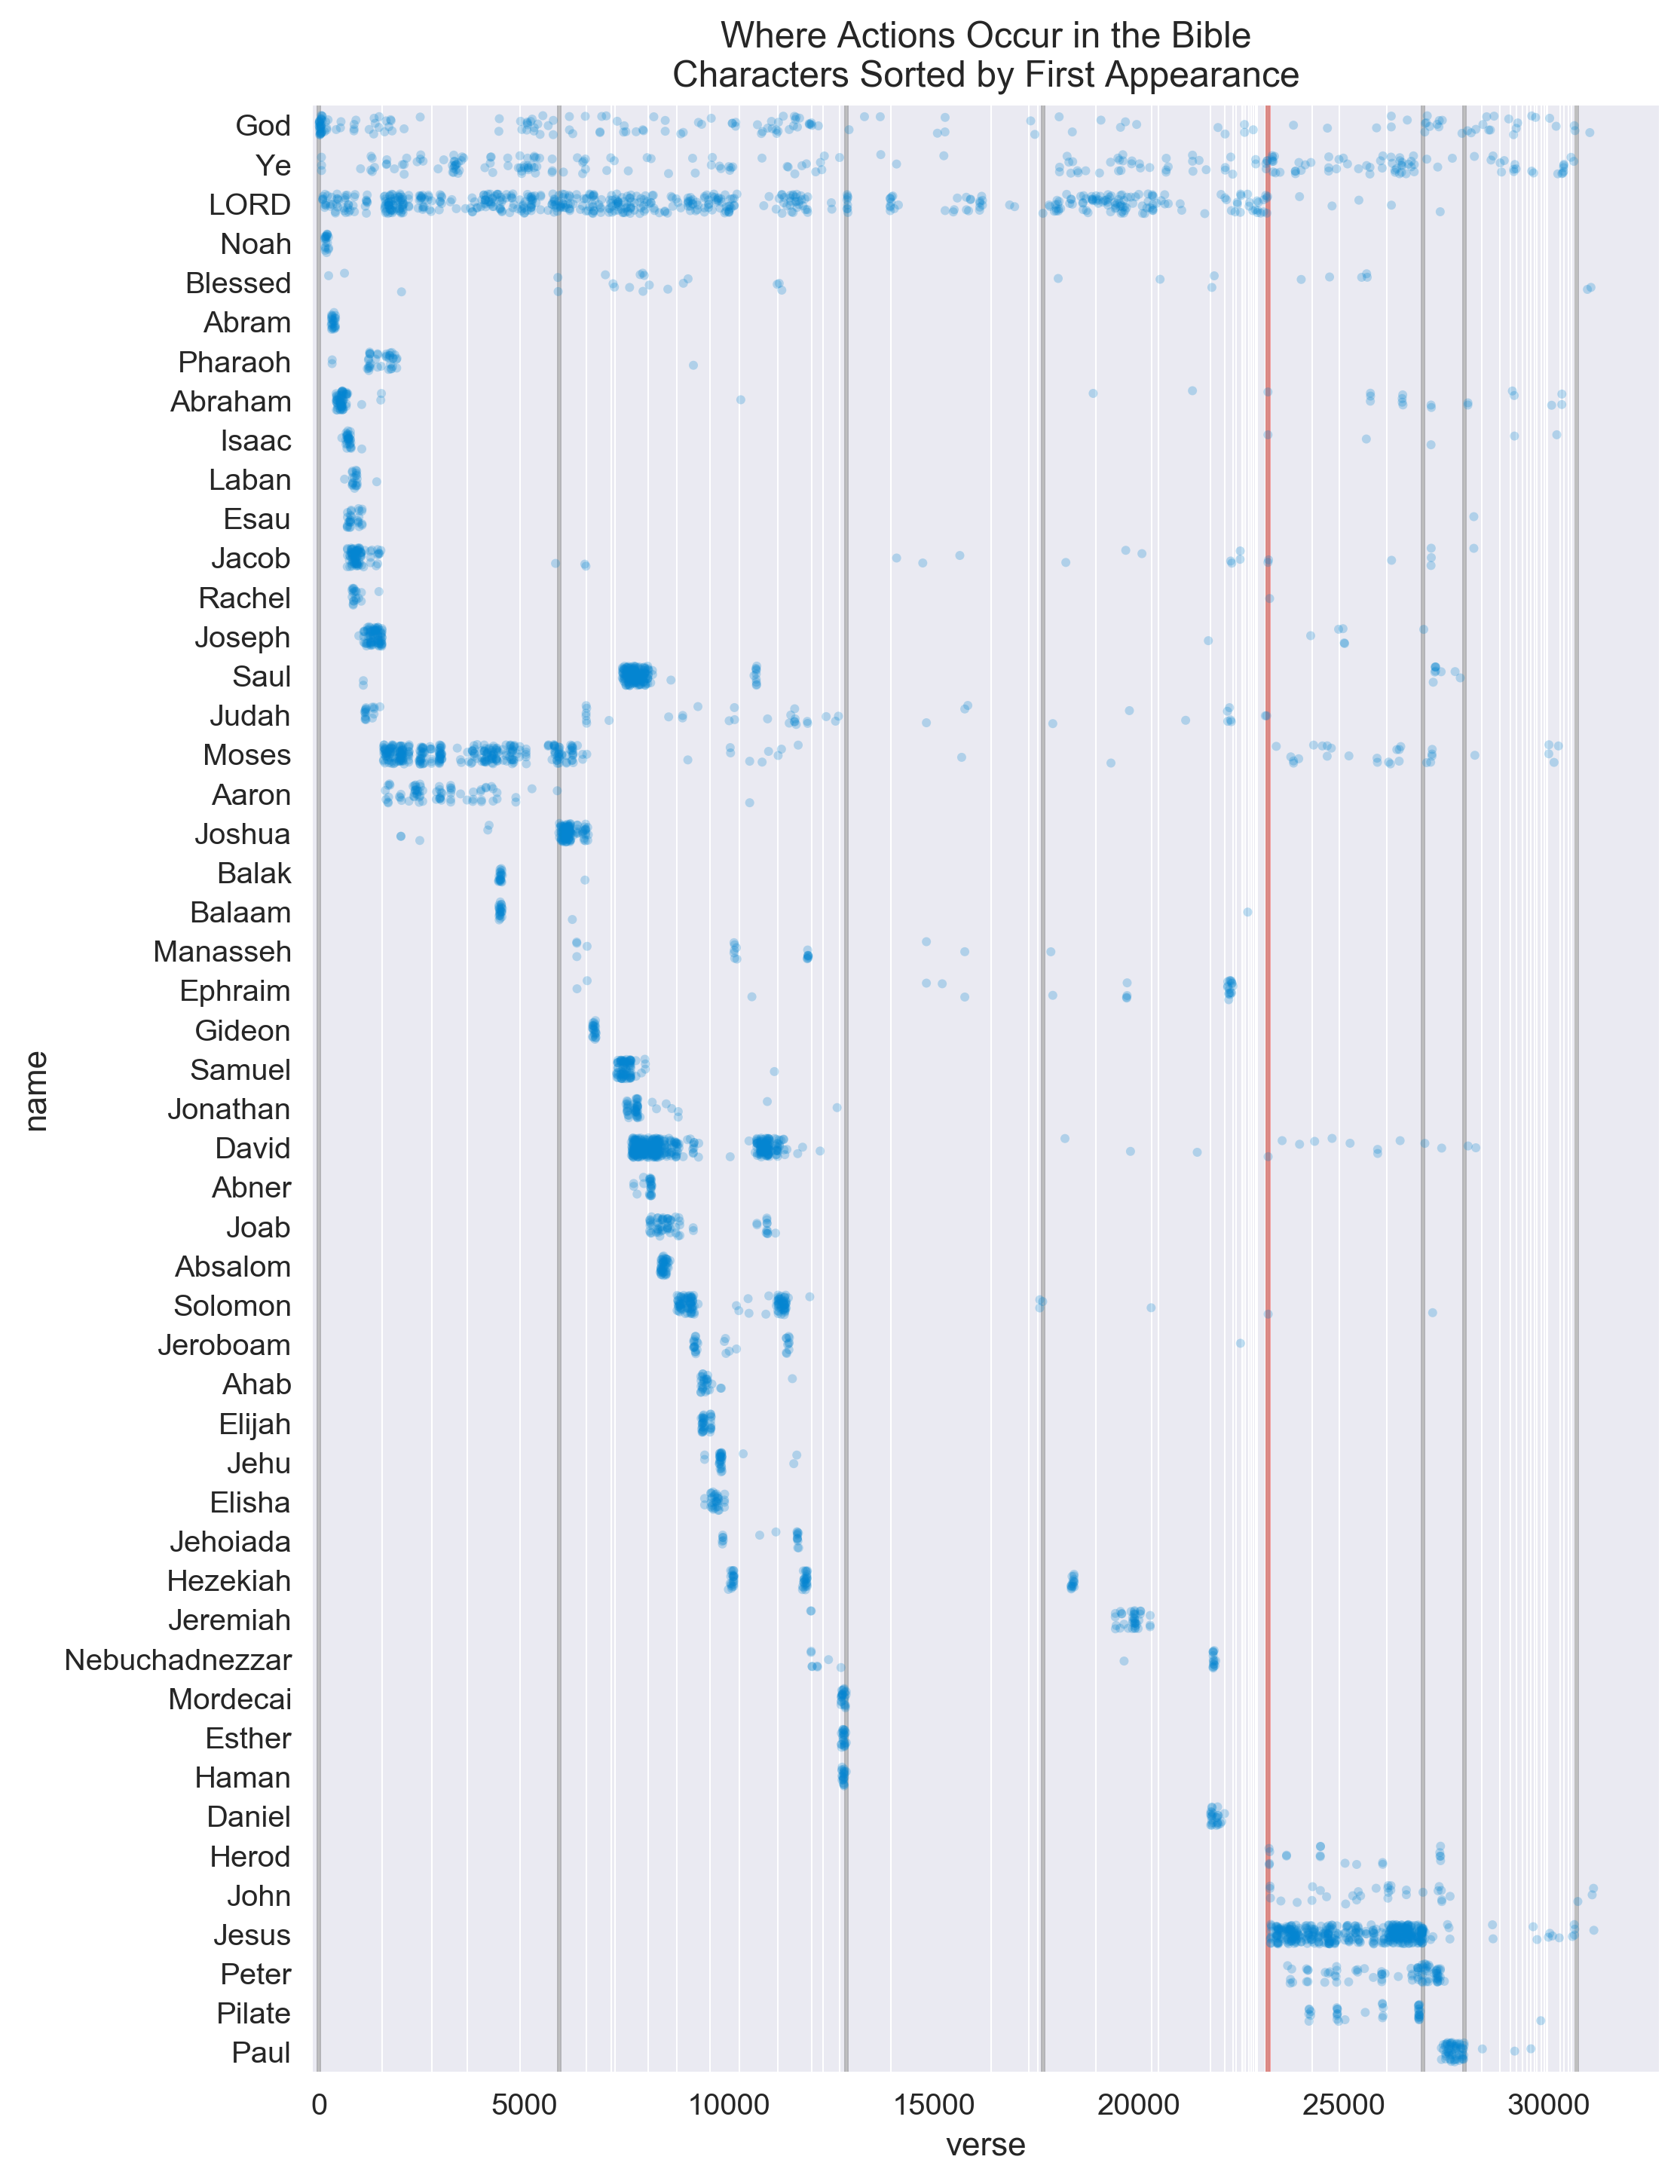

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(context='notebook', style='dark')

most_frequent_actors = list(action_df['name'].value_counts().index[:50])
top_actors_df = action_df[action_df['name'].isin(most_frequent_actors)].copy()
book_locations = (pd.DataFrame(bible_json)
                  .reset_index()
                  .groupby('book_id')['index']
                  .min()
                  .to_dict()
                 )

fig, ax = plt.subplots(figsize=(8,12), dpi=144*2)
sns.stripplot(x='verse', y='name', 
              data=top_actors_df, ax=ax,
              color='xkcd:cerulean',
              size=3, alpha=0.25, jitter=0.25)

sns.despine(bottom=True, left=True)

for book, verse_num in book_locations.items():
    ax.axvline(verse_num, alpha=1, lw=0.5, color='w')

divisions = [1, 6, 18, 23, 40, 44, 45, 65]
for div in divisions:
    ax.axvline(book_locations[div], alpha=0.5, lw=1.5, color='grey')

ax.axvline(book_locations[40], alpha=0.5, lw=1.75, color='xkcd:coral')

ax.set_xlim(left=-150)

ax.set_title("Where Actions Occur in the Bible\nCharacters Sorted by First Appearance");

## Visual analysis

- God is densely referred to at the beginning of the Bible, in Genesis.
- LORD stops being used as an entity in books of the New Testament.
- We can see the first time Paul is referred to in the middle of Acts. (first book after the gospels)
- There's not a lot of mention of entities in the _Wisdom & Poetry_ Sections of the Bible.
- Jesus' life is densely chronicled throughougt the gospels.
- Pilate appears at the end of each of the gospels.


## Issues with this Approach
- Entity Recognition can't tell the difference between two different people with the same name.
    - King Saul (Old Testament)
    - Paul (The Apostle) is referred to as Saul until midway through the book of Acts
- Some nouns are obviously not actual entities. (Ye)
- Some nouns could use more context with full names. (Pilate)

## Next Steps
As always, there are several ways to extend and improve this analysis. Here's a few I've thought of while writing this:
1. Find relationships between entities using dependency relations and understand the characters through a network analysis approach.
2. Improve the entity extraction to capture entities beyond single names
3. Do an analysis of non-person entities and their linguistic relations - which locations are mentioned throughout the Bible?


## Wrap Up
We can get pretty far doing some interesting analysis by only using token-level attributes from text! In this blog post, we covered three key NLP tools:
1. **Part of Speech Tagging** - What type of word is this?
2. **Dependency Parsing** - How is this word related to other words in this sentence?
3. **Named Entity Recognition** - Is this word a proper noun?

We applied these three tools together to discover who the major actors are in the Bible and what actions they take. We plotted those actors and actions to understand where each actor had their major actions.

### Thanks
Thanks to [Vicki Boykis](http://www.vickiboykis.com/) and [Austin Rochford](http://austinrochford.com/) for providing feedback on earlier versions of this post. 